# Module 3 Project: Daily Climatology and Weather Plot

**Student Name:** Nathan Makowski  
**Course:** ATMS 523 / Weather and Climate Data Analytics  
**Date:** 2025-10-08  

---

### Project Description

This notebook demonstrates the following:

1. Downloading daily GHCN station data from Amazon Web Services for the Metro Detroit station.
2. Computing the daily climatology (1991–2020) including:
   - Record high and low temperatures
   - Average high and low temperatures for each calendar day
3. Extracting actual daily temperatures for a specific year (e.g., 2024).
4. Plotting daily temperatures:
   - Actual high/low temperatures
   - Average high/low temperatures (1991–2020)
   - Record high/low temperatures
5. Includes intermediate checks to inspect the data at key steps.
6. Excludes leap day (Feb 29) from all calculations.

In [13]:
# -------------------------------
# Daily Climatology and Plotting
# -------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [14]:
# -------------------------------
# Function to download GHCN station data and compute daily climatology
# -------------------------------

def daily_climatology(station_id, start_year=1991, end_year=2020):
    """
    Download GHCN daily data for a station and compute:
    - Record max and min temperatures for each day-of-year (DOY)
    - Average max and min temperatures for 1991-2020
    
    Returns a DataFrame with columns:
    ['record_max_temp','record_min_temp','average_max_temp','average_min_temp',
     'record_max_year','record_min_year']
    """
    # Read station parquet data from AWS
    df = pd.read_parquet(
        f"s3://noaa-ghcn-pds/parquet/by_station/STATION={station_id}/",
        storage_options={"anon": True}
    )
    print("Initial data loaded:")
    print(df.head())

    # Convert date
    df['DATE'] = pd.to_datetime(df['DATE'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d')))
    df = df.set_index('DATE').sort_index()
    print("\nAfter converting DATE to datetime and sorting:")
    print(df.head())

    # Separate TMAX and TMIN
    df_tmax = df[df['ELEMENT']=='TMAX'].copy()
    df_tmin = df[df['ELEMENT']=='TMIN'].copy()

    df_tmax['VALUE_C'] = df_tmax['DATA_VALUE'] / 10.0
    df_tmin['VALUE_C'] = df_tmin['DATA_VALUE'] / 10.0

    print(f"\nTMAX sample:\n{df_tmax.head()}")
    print(f"\nTMIN sample:\n{df_tmin.head()}")

    # Function to compute daily stats
    def daily_stats(df_elem):
        df_elem = df_elem[
            ~((df_elem.index.month == 2) & (df_elem.index.day == 29))  # drop Feb 29
        ]
        df_elem = df_elem[(df_elem.index.year >= start_year) & (df_elem.index.year <= end_year)]
        df_elem['DOY'] = df_elem.index.day_of_year
        df_elem['YEAR'] = df_elem.index.year
        
        print(f"\nData after filtering years and dropping Feb 29 ({df_elem.index.min()} to {df_elem.index.max()}):")
        print(df_elem.head())

        grouped = df_elem.groupby('DOY')

        record_max = grouped['VALUE_C'].max()
        record_max_year = grouped.apply(lambda x: x.loc[x['VALUE_C'].idxmax(), 'YEAR'])
        record_min = grouped['VALUE_C'].min()
        record_min_year = grouped.apply(lambda x: x.loc[x['VALUE_C'].idxmin(), 'YEAR'])
        average = grouped['VALUE_C'].mean()

        return pd.DataFrame({
            'record_temp': record_max if df_elem['ELEMENT'].iloc[0]=='TMAX' else record_min,
            'average_temp': average,
            'record_year': record_max_year if df_elem['ELEMENT'].iloc[0]=='TMAX' else record_min_year
        })

    tmax_stats = daily_stats(df_tmax).rename(columns={'record_temp':'record_max_temp',
                                                      'average_temp':'average_max_temp',
                                                      'record_year':'record_max_year'})
    tmin_stats = daily_stats(df_tmin).rename(columns={'record_temp':'record_min_temp',
                                                      'average_temp':'average_min_temp',
                                                      'record_year':'record_min_year'})
    
    print("\nTMAX daily stats sample:")
    print(tmax_stats.head())
    print("\nTMIN daily stats sample:")
    print(tmin_stats.head())

    # Combine into one DataFrame
    clim = pd.DataFrame({
        'record_max_temp': tmax_stats['record_max_temp'],
        'record_max_year': tmax_stats['record_max_year'],
        'average_max_temp': tmax_stats['average_max_temp'],
        'average_min_temp': tmin_stats['average_min_temp'],
        'record_min_temp': tmin_stats['record_min_temp'],
        'record_min_year': tmin_stats['record_min_year']
    })

    print("\nCombined climatology sample:")
    print(clim.head())

    return clim, df_tmax, df_tmin

In [15]:
# -------------------------------
# Prepare daily data for a specific year
# -------------------------------

def daily_year_data(df_tmax, df_tmin, year):
    """
    Prepare daily actual temperatures for a specific year
    """
    df_tmax_year = df_tmax[df_tmax.index.year == year][['VALUE_C']].rename(columns={'VALUE_C':'TMAX'})
    df_tmin_year = df_tmin[df_tmin.index.year == year][['VALUE_C']].rename(columns={'VALUE_C':'TMIN'})

    print(f"\nTMAX for {year} sample:")
    print(df_tmax_year.head())
    print(f"\nTMIN for {year} sample:")
    print(df_tmin_year.head())
    
    # Merge on date index
    df_year = df_tmax_year.join(df_tmin_year, how='inner')
    
    # Drop Feb 29 if exists
    df_year = df_year[~((df_year.index.month==2) & (df_year.index.day==29))]
    
    df_year['DOY'] = df_year.index.day_of_year

    print(f"\nMerged daily data for {year} sample:")
    print(df_year.head())

    return df_year

In [17]:
# -------------------------------
# Plot function
# -------------------------------

def plot_year_temperatures(clim, df_year, city_name='Detroit', year=2024):
    """
    Plot record, average, and actual TMAX/TMIN for a given year
    """
    plt.figure(figsize=(15,6))
    
    # Actual
    plt.plot(df_year['DOY'], df_year['TMAX'], color='red', alpha=0.7, label='Actual Max')
    plt.plot(df_year['DOY'], df_year['TMIN'], color='blue', alpha=0.7, label='Actual Min')
    
    # Climatology
    plt.plot(clim.index, clim['average_max_temp'], color='orange', linestyle='--', label='Average Max (1991-2020)')
    plt.plot(clim.index, clim['average_min_temp'], color='cyan', linestyle='--', label='Average Min (1991-2020)')
    
    # Records
    plt.plot(clim.index, clim['record_max_temp'], color='darkred', linestyle=':', label='Record Max')
    plt.plot(clim.index, clim['record_min_temp'], color='darkblue', linestyle=':', label='Record Min')
    
    plt.title(f'Daily Temperatures for {city_name} in {year}')
    plt.xlabel('Day of Year')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


## Daily Temperatures for 2024

This plot displays the daily temperatures for **Detroit Metro Airport** in **2024**, including:

- **Actual Temperatures:**  
  - Red line: Actual daily maximum temperature  
  - Blue line: Actual daily minimum temperature

- **Climatological Averages (1991–2020):**  
  - Orange dashed line: Average daily maximum temperature  
  - Cyan dashed line: Average daily minimum temperature

- **Records (1991–2020):**  
  - Dark red dotted line: Record daily maximum temperature  
  - Dark blue dotted line: Record daily minimum temperature

Leap day (February 29) is excluded from both the climatology and 2024 data.

Initial data loaded:
            ID      DATE  DATA_VALUE M_FLAG Q_FLAG S_FLAG OBS_TIME ELEMENT
0  USW00094847  19950709           0   None   None      X     None    ACMC
1  USW00094847  19650101         100   None   None      X     None    ACMH
2  USW00094847  19650102         100   None   None      X     None    ACMH
3  USW00094847  19650103          40   None   None      X     None    ACMH
4  USW00094847  19650104          90   None   None      X     None    ACMH

After converting DATE to datetime and sorting:
                     ID  DATA_VALUE M_FLAG Q_FLAG S_FLAG OBS_TIME ELEMENT
DATE                                                                     
1942-08-01  USW00094847         229      H   None      S     None    TAVG
1942-08-02  USW00094847         241      H   None      S     None    TAVG
1942-08-03  USW00094847         218      H   None      S     None    TAVG
1942-08-04  USW00094847         206      H   None      S     None    TAVG
1942-08-05  USW00094847         201  

/tmp/ipykernel_8774/2814963747.py:54: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  record_max_year = grouped.apply(lambda x: x.loc[x['VALUE_C'].idxmax(), 'YEAR'])
/tmp/ipykernel_8774/2814963747.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  record_min_year = grouped.apply(lambda x: x.loc[x['VALUE_C'].idxmin(), 'YEAR'])
/tmp/ipykernel_8774/2814963747.py:54: FutureWarning: DataFrameGroupBy.apply operated on the 


Data after filtering years and dropping Feb 29 (1991-01-01 00:00:00 to 2020-12-31 00:00:00):
                     ID  DATA_VALUE M_FLAG Q_FLAG S_FLAG OBS_TIME ELEMENT  \
DATE                                                                        
1991-01-01  USW00094847        -106   None   None      0     2400    TMIN   
1991-01-02  USW00094847         -56   None   None      0     2400    TMIN   
1991-01-03  USW00094847        -106   None   None      0     2400    TMIN   
1991-01-04  USW00094847        -117   None   None      0     2400    TMIN   
1991-01-05  USW00094847         -78   None   None      0     2400    TMIN   

            VALUE_C  DOY  YEAR  
DATE                            
1991-01-01    -10.6    1  1991  
1991-01-02     -5.6    2  1991  
1991-01-03    -10.6    3  1991  
1991-01-04    -11.7    4  1991  
1991-01-05     -7.8    5  1991  

TMAX daily stats sample:
     record_max_temp  average_max_temp  record_max_year
DOY                                                  

/tmp/ipykernel_8774/2814963747.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  record_min_year = grouped.apply(lambda x: x.loc[x['VALUE_C'].idxmin(), 'YEAR'])



TMAX for 2024 sample:
            TMAX
DATE            
2024-01-01   2.2
2024-01-02   0.6
2024-01-03   1.7
2024-01-04   0.0
2024-01-05   0.0

TMIN for 2024 sample:
            TMIN
DATE            
2024-01-01  -0.5
2024-01-02  -1.0
2024-01-03   0.0
2024-01-04  -7.1
2024-01-05  -7.1

Merged daily data for 2024 sample:
            TMAX  TMIN  DOY
DATE                       
2024-01-01   2.2  -0.5    1
2024-01-02   0.6  -1.0    2
2024-01-03   1.7   0.0    3
2024-01-04   0.0  -7.1    4
2024-01-05   0.0  -7.1    5


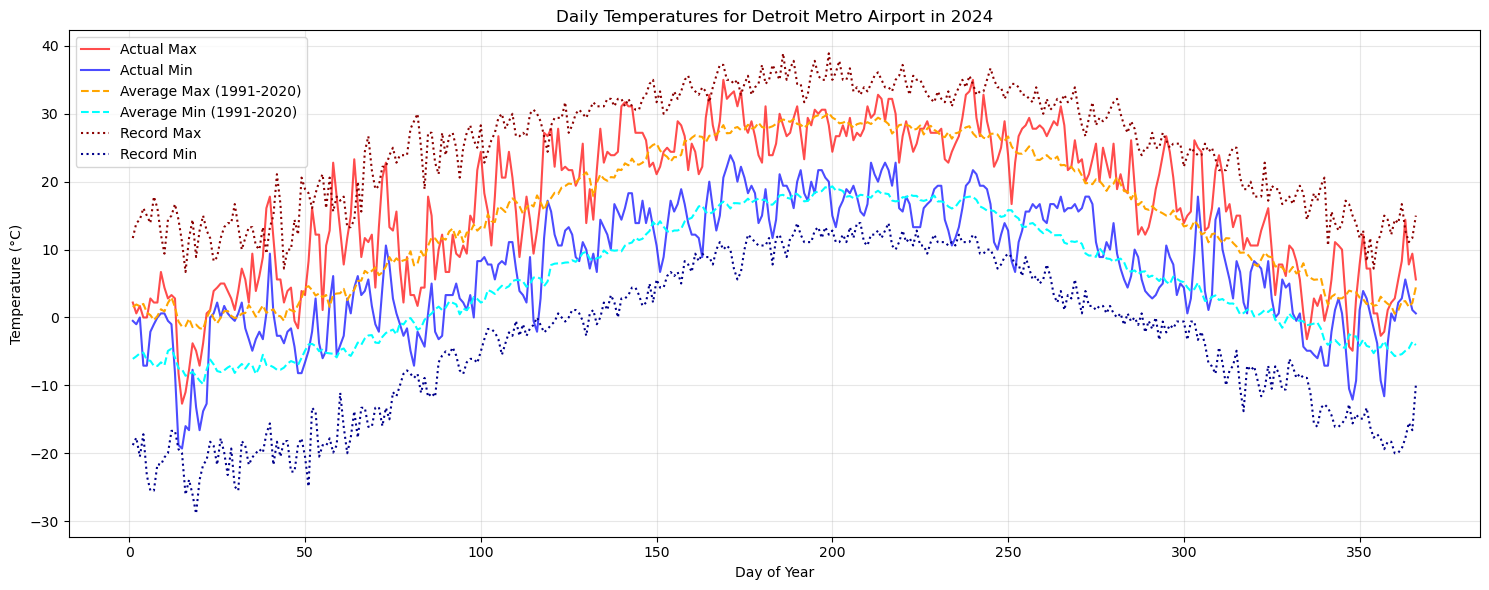

In [19]:
# -------------------------------
# For Detroit Metro Airport (USW00094847)
# -------------------------------

station_id = "USW00094847"
clim, df_tmax, df_tmin = daily_climatology(station_id)
df_2024 = daily_year_data(df_tmax, df_tmin, 2024)
plot_year_temperatures(clim, df_2024, city_name='Detroit Metro Airport', year=2024)